In [1]:
import os 
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "=========="*8 + "%s" % nowtime)

### 1. 准备数据

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

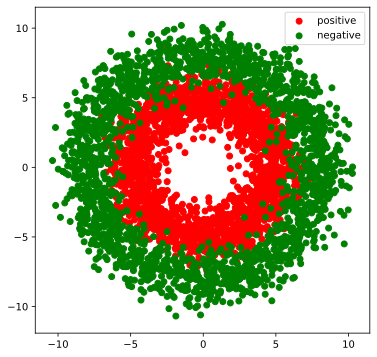

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环分布, label = 1
r_p = 5.0 + torch.normal(0.0, 1.0, size = [n_positive, 1]) # 离散正态分布
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis = 1)
Yp = torch.ones_like(r_p)

# 生成负样本, 大圆环分布, label = 0
r_n = 8.0 + torch.normal(0.0, 1.0, size = [n_negative, 1])
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis = 1)
Yn = torch.zeros_like(r_n)

# 汇总样本
X = torch.cat([Xp, Xn], axis = 0)
Y = torch.cat([Yp, Yn], axis = 0)

# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c = 'r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c = 'g')
plt.legend(['positive', 'negative'])

# 样本 Xp: 2000*2 Xn: 2000*2 X: 4000*2
# 样本标签 Yp: 2000*1 Yn: 2000*1 Y: 4000*1

In [4]:
# 构建数据管道
ds = TensorDataset(X, Y)
dl = DataLoader(ds, shuffle = True, batch_size = 10)
for f, l in dl:
    print(f)
    print(l)
    break

tensor([[ 3.3508,  2.9207],
        [-9.5895,  1.3075],
        [-7.3835,  4.8160],
        [-1.0087, -5.3976],
        [ 6.6055, -5.5305],
        [-3.1174, -6.1210],
        [ 6.9674,  2.4327],
        [-4.4253, -5.9450],
        [-8.4153, -0.7078],
        [-2.3715,  4.8222]])
tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])


### 2. 定义模型

In [5]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 1)
    
    # 正向传播
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y
    
    # 损失函数
    def loss_func(self, y_pred, y_true):
        return nn.BCELoss()(y_pred, y_true)
    
    # 评估函数（准确率）
    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(y_pred > 0.5,
                             torch.ones_like(y_pred, dtype = torch.float32), 
                             torch.zeros_like(y_pred, dtype = torch.float32))
        acc = torch.mean(1 - torch.abs(y_true - y_pred))
        return acc
    
    # 优化器
    @property
    def optimizer(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
model = DNNModel()    

In [6]:
# 测试模型结构

(features, labels) = next(iter(dl))
predictions = model(features)
loss = model.loss_func(predictions, labels)
metric = model.metric_func(predictions, labels)

print("init loss:",loss.item())
print("init metric:",metric.item())

init loss: 0.6820082664489746
init metric: 0.4000000059604645


### 3. 训练模型

In [7]:
def train_step(model, features, labels):
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)
    
    # 反向传播求梯度
    loss.backward()
    
    # 更新参数，梯度清零
    model.optimizer.step()
    model.optimizer.zero_grad()
    
    return loss.item(), metric.item()

In [8]:
# 测试train_step效果
features, labels = next(iter(dl))
train_step(model, features, labels)

(0.7621020674705505, 0.30000001192092896)

In [9]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        loss_list, metric_list = [], []
        for features, labels in dl:
            lossi, metrici = train_step(model, features, labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)
        
        if epoch % 100 == 0:
            printbar()
            print("epoch =", epoch, "loss = ", loss, "metric = ", metric)

train_model(model, epochs=300)


================================================================================2021-01-28 22:32:49
epoch = 100 loss =  0.2321095206910104 metric =  0.924749992787838

================================================================================2021-01-28 22:33:31
epoch = 200 loss =  0.2409597639229105 metric =  0.9294999928772449

================================================================================2021-01-28 22:34:12
epoch = 300 loss =  0.24482943337095547 metric =  0.9297499918937683


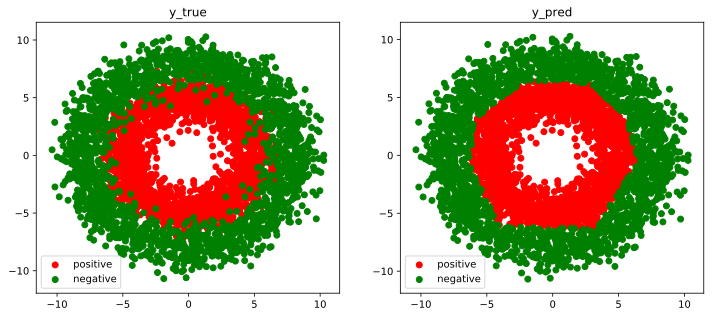

In [10]:
# 结果可视化

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c = "r")
ax1.scatter(Xn[:, 0], Xn[:, 1], c = "g")
ax1.legend(["positive", "negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1],c = "r")
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1],c = "g")
ax2.legend(["positive", "negative"]);
ax2.set_title("y_pred");